# Early Fusion

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
import torchvision.models as models

class EarlyFusionModel(nn.Module):
    def __init__(self):
        super(EarlyFusionModel, self).__init__()
        self.image_encoder = models.resnet50(pretrained=True)
        self.image_encoder.fc = nn.Linear(self.image_encoder.fc.in_features, 256)

        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.text_fc = nn.Linear(self.text_encoder.config.hidden_size, 256)

        self.fusion = nn.Linear(512, 256)
        self.classifier = nn.Linear(256, 10)

    def forward(self, image, text):
        image_features = self.image_encoder(image)

        text_outputs = self.text_encoder(**text)
        text_features = self.text_fc(text_outputs.last_hidden_state[:, 0, :])

        combined_features = torch.cat((image_features, text_features), dim=1)
        fused_features = self.fusion(combined_features)

        output = self.classifier(fused_features)
        return output

# Example usage
model = EarlyFusionModel()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
import matplotlib.pyplot as plt

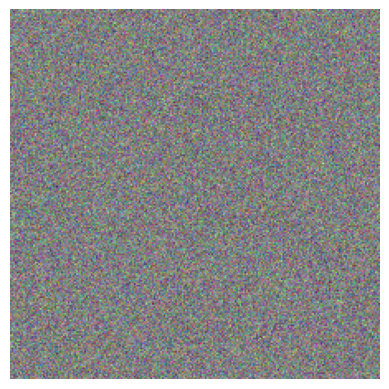

{'input_ids': tensor([[ 101, 2023, 2003, 2019, 2742, 6251,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}
tensor([[-0.1094,  0.0168, -0.2509, -0.0918, -0.0726, -0.1120, -0.1318, -0.1867,
         -0.0761, -0.1931]], grad_fn=<AddmmBackward0>)


In [ ]:
text_inputs = tokenizer("This is an example sentence", return_tensors="pt")
image_inputs = torch.randn(1, 3, 224, 224)  # Example image tensor
tensor = image_inputs.squeeze(0)
tensor = tensor - tensor.min()  # Menggeser nilai minimum ke 0
tensor = tensor / tensor.max()  # Membagi dengan nilai maksimum untuk membawa ke rentang [0, 1]

# Menukar dimensi dari (C, H, W) ke (H, W, C) agar sesuai dengan format gambar
tensor = tensor.permute(1, 2, 0).numpy()

# Menampilkan gambar
plt.imshow(tensor)
plt.axis('off')  # Menghilangkan sumbu
plt.show()
output = model(image_inputs, text_inputs)
print(text_inputs)
print(output)

# Late Fusion

In [ ]:
class LateFusionModel(nn.Module):
    def __init__(self):
        super(LateFusionModel, self).__init__()
        self.image_encoder = models.resnet50(pretrained=True)
        self.image_encoder.fc = nn.Linear(self.image_encoder.fc.in_features, 256)

        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.text_fc = nn.Linear(self.text_encoder.config.hidden_size, 256)

        self.classifier = nn.Linear(512, 10)

    def forward(self, image, text):
        image_features = self.image_encoder(image)

        text_outputs = self.text_encoder(**text)
        text_features = self.text_fc(text_outputs.last_hidden_state[:, 0, :])

        combined_features = torch.cat((image_features, text_features), dim=1)

        output = self.classifier(combined_features)
        return output

In [ ]:
# Example usage
model = LateFusionModel()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_inputs = tokenizer("This is an example sentence", return_tensors="pt")
image_inputs = torch.randn(1, 3, 224, 224)  # Example image tensor
output = model(image_inputs, text_inputs)
print(output)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[ 0.0402, -0.0400, -0.0491, -0.1909,  0.0881, -0.1295,  0.1068, -0.0766,
         -0.2441,  0.0706]], grad_fn=<AddmmBackward0>)


# Hybrid Fusion

In [ ]:
class AttentionFusionModel(nn.Module):
    def __init__(self):
        super(AttentionFusionModel, self).__init__()
        self.image_encoder = models.resnet50(pretrained=True)
        self.image_encoder.fc = nn.Linear(self.image_encoder.fc.in_features, 256)

        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.text_fc = nn.Linear(self.text_encoder.config.hidden_size, 256)

        self.attention = nn.MultiheadAttention(embed_dim=256, num_heads=4)
        self.classifier = nn.Linear(256, 10)

    def forward(self, image, text):
        image_features = self.image_encoder(image).unsqueeze(0)

        text_outputs = self.text_encoder(**text)
        text_features = self.text_fc(text_outputs.last_hidden_state[:, 0, :]).unsqueeze(0)

        combined_features = torch.cat((image_features, text_features), dim=0)
        attn_output, _ = self.attention(combined_features, combined_features, combined_features)

        fused_features = attn_output.mean(dim=0)

        output = self.classifier(fused_features)
        return output

In [ ]:
# Example usage
model = AttentionFusionModel()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_inputs = tokenizer("This is an example sentence", return_tensors="pt")
image_inputs = torch.randn(1, 3, 224, 224)  # Example image tensor
output = model(image_inputs, text_inputs)
print(output)

tensor([[ 0.0064, -0.0634, -0.0740, -0.0072, -0.0275,  0.0575, -0.0627,  0.0648,
          0.0424, -0.0985]], grad_fn=<AddmmBackward0>)
